# [LTFS Data Science FinHack ( ML Hackathon)](https://datahack.analyticsvidhya.com/contest/ltfs-datascience-finhack-an-online-hackathon/)

### Notes -
I have used [modin](https://github.com/modin-project/modin) package which speeds up pandas library.

#### To install modin
`!pip install modin` then also do a `!pip install setproctitle`<br>
drop the initial '!' from above commands if you run in a Terminal. I am using [Azure Notebook](https://notebooks.azure.com)

In [1]:
import numpy as np
import pandas as pd

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Reading the data from disk

In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

### Lets check the data quality first

In [5]:
df_train.shape

(233154, 41)

In [6]:
# Percentage of null values in each feature
def get_nulls(X):
    key_string = 'Null '+'/ '+str(X.shape[0])
    temp = pd.DataFrame({key_string: X.isnull().sum(),
                         'Null %age': round(X.isnull().sum()/ X.shape[0]*100,2)})
    temp = temp.loc[temp[key_string] > 0,:]
    return temp

In [7]:
get_nulls(df_train)

,Null / 233154,Null %age
Employment.Type,7661,3.29


In [8]:
get_nulls(df_test)

,Null / 112392,Null %age
Employment.Type,3443,3.06


Among 41 columns only 1 columns **Employment.type** is having null values. Also, only about 3% of rows have nulls. But if we see it more carefully, since our dataset is pretty large the **3% is actually 7661 rows**.<br> Entire model can be built using such data. So why drop these rows. We can use **segmentation** here easily.

### Lets do some EDA

#### Basic data heads and shapes

In [9]:
df_train.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [10]:
df_train.shape

(233154, 41)

In [11]:
df_test.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES
0,655269,53478,63558,86.54,67,22807,45,1497,01-01-74,Salaried,03-11-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
1,723482,55513,63163,89.45,67,22807,45,1497,20-05-85,Self employed,20-11-18,6,1998,1,1,0,0,0,0,749,C-Very Low Risk,2,1,0,43898,48780,48780,0,0,0,0,0,0,5605,0,1,0,0yrs 8mon,1yrs 0mon,1
2,758529,65282,84320,79.93,78,23135,86,2071,14-10-95,Salaried,29-11-18,4,1646,1,1,1,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
3,763449,46905,63896,76.58,78,17014,45,2070,01-06-73,Self employed,29-11-18,4,1646,1,1,0,0,0,0,14,Not Scored: Only a Guarantor,1,1,1,132480,255000,255000,0,0,0,0,0,0,0,0,0,0,2yrs 5mon,2yrs 5mon,0
4,708663,51428,63896,86.08,78,17014,45,2069,01-06-72,Salaried,17-11-18,4,1646,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0


In [12]:
df_test.shape

(112392, 40)

#### UniqueID

In [13]:
# Add column labels to to_drop list to drop them at once
to_drop = []

In [14]:
# UniqueID is of no use for model
to_drop.append('UniqueID')

#### disbursed amount

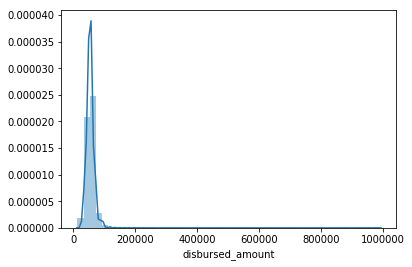

In [15]:
# disbursed amount
sns.distplot(df_train['disbursed_amount'])

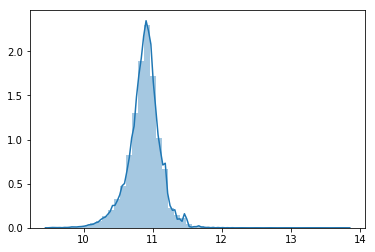

In [16]:
sns.distplot(np.log(df_train['disbursed_amount'].values))

In [17]:
# So we will transform disbursed_amount to log scale
def to_log(X, labels):
    for label in labels:
        X[label] = np.log(df_train[label].values)
    return X

In [18]:
log_labels = []

In [19]:
log_labels.append('disbursed_amount')

#### asset_cost

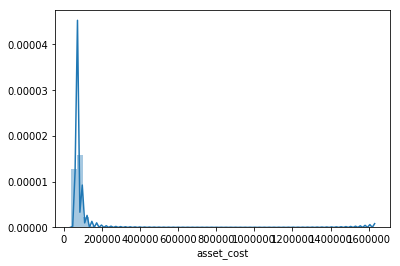

In [20]:
# asset_cost
sns.distplot(df_train['asset_cost'])

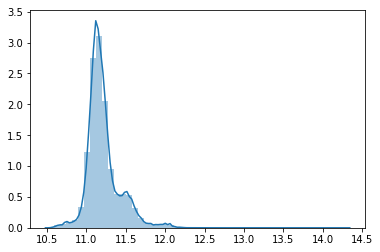

In [21]:
sns.distplot(np.log(df_train['asset_cost'].values))

In [22]:
log_labels.append('asset_cost')

#### ltv

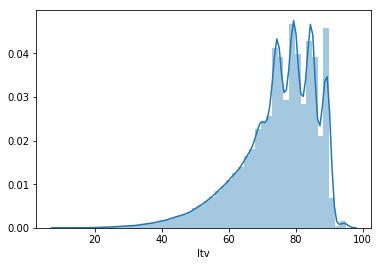

In [23]:
sns.distplot(df_train['ltv'])

#### branch_id

In [24]:
df_train['branch_id'].nunique()

82

In [25]:
def cat_feature_vs_target(X, label, target):
    
    temp = df_train.groupby(by=label, as_index=False)[[target]].sum()

    temp1 = df_train.groupby(by=label, as_index=False)[[target]].count()

    temp['% age'] = temp[target]/temp1[target]*100

    temp['total'] = temp1[target]
    return temp

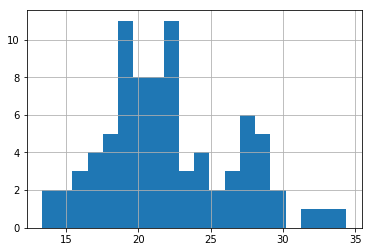

In [26]:
br_id = cat_feature_vs_target(df_train, 'branch_id', 'loan_default')
br_id.sort_values(by='% age', ascending=False)['% age'].hist(bins=20)

#### supplier_id

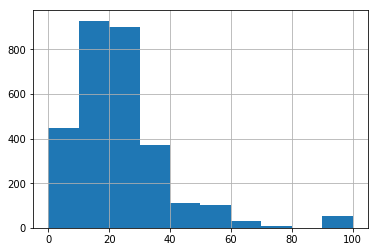

In [27]:
# This represents the shop that sold the vehicle to customer
sup_id = cat_feature_vs_target(df_train, 'supplier_id', 'loan_default')
sup_id.sort_values(by='% age', ascending=False)['% age'].hist()

#### manufacturer_id

In [28]:
# This represents the brand of vehicle
sup_id = cat_feature_vs_target(df_train, 'manufacturer_id', 'loan_default')

In [29]:
sup_id.sort_values(by='% age', ascending=False)

,manufacturer_id,loan_default,% age,total
9,153,4,33.333333,12
1,48,4554,27.253142,16710
0,45,12939,22.849928,56626
6,120,2132,22.074964,9658
2,49,2236,21.878669,10220
4,67,523,21.746362,2405
3,51,5657,20.794736,27204
5,86,22410,20.459401,109534
7,145,156,20.051414,778
8,152,0,0.000000,6


#### Current_pincode_ID

In [30]:
pin = cat_feature_vs_target(df_train, 'Current_pincode_ID', 'loan_default')

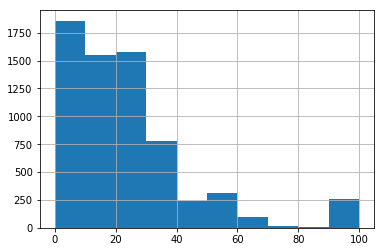

In [31]:
pin.sort_values(by='% age', ascending=False)['% age'].hist()

#### Date.of.Birth

In [32]:
import datetime as dt

In [33]:
def calc_age(a, b):
    age = (pd.to_datetime(b, format="%d-%m-%y") - pd.to_datetime(a, format="%d-%m-%y"))
    age = age.apply(lambda x: x.days/365)
    age = age.apply(lambda x: x if x > 0 else x+100)
    return age

In [34]:
df_train['Age'] = calc_age(df_train['Date.of.Birth'], df_train['DisbursalDate'])

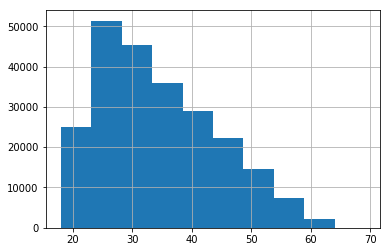

In [35]:
df_train['Age'].hist()

In [36]:
to_drop.append('Date.of.Birth')

#### Employment.Type

In [37]:
df_train['Employment.Type'].value_counts(dropna=False)

Self employed    127635
Salaried          97858
NaN                7661
Name: Employment.Type, dtype: int64

In [38]:
#Employment type may be null for students. If they dont have any Bureu History.
def fill_na_emp(X):
    X.loc[(X['PERFORM_CNS.SCORE.DESCRIPTION']=="No Bureau History Available")&
                 (X['Employment.Type'].isnull()),'Employment.Type'] = 'Student'
    X.loc[(X['PERFORM_CNS.SCORE.DESCRIPTION']!="No Bureau History Available")&
                 (X['Employment.Type'].isnull()),'Employment.Type'] = 'Unknown'

#### DisbursalDate

In [39]:
# Analysis based on year, month, week of month like first week seconda week etc... 
# For now drop.
to_drop.append('DisbursalDate')

#### State_ID

In [40]:
state = cat_feature_vs_target(df_train, 'State_ID', 'loan_default')

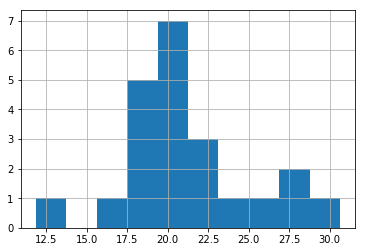

In [41]:
state.sort_values(by='% age', ascending=False)['% age'].hist()

#### Employee_code_ID

In [42]:
df_train['Employee_code_ID'].nunique()

3270

In [43]:
empcode = cat_feature_vs_target(df_train, 'Employee_code_ID', 'loan_default')

In [44]:
empcode.sort_values(by='% age', ascending=False).head(100)

,Employee_code_ID,loan_default,% age,total
3269,3795,1,100.000000,1
3245,3771,1,100.000000,1
280,350,1,100.000000,1
3159,3685,1,100.000000,1
2582,3101,1,100.000000,1
3215,3741,2,100.000000,2
3220,3746,1,100.000000,1
2533,3052,1,100.000000,1
3230,3756,2,100.000000,2
843,1046,3,100.000000,3


In [45]:
# Combination of employee code id, branch id, pincode id 

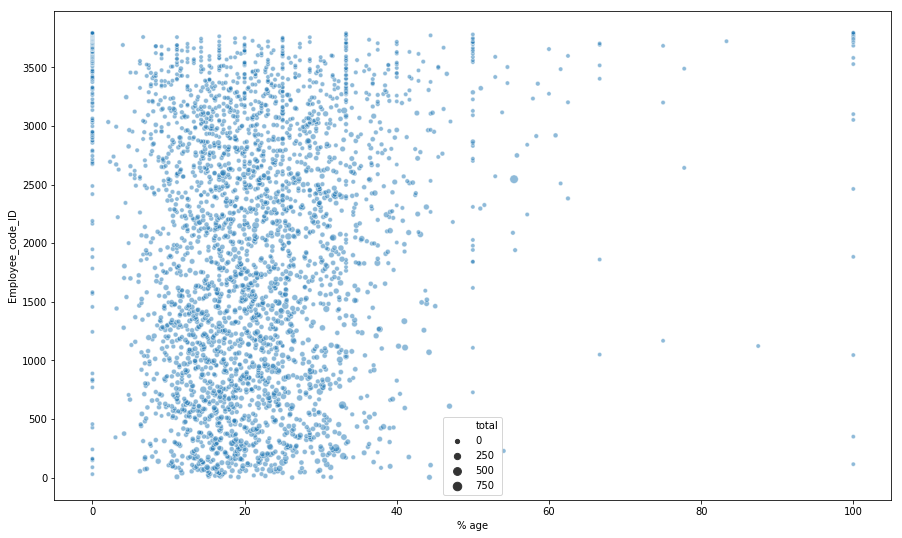

In [46]:
plt.figure(figsize=(15,9))
sns.scatterplot(data=empcode, x= '% age', y='Employee_code_ID',alpha=0.5, size='total')

#### MobileNo_Avl_Flag

In [47]:
mobile = cat_feature_vs_target(df_train, 'MobileNo_Avl_Flag', 'loan_default')

In [48]:
mobile.sort_values(by='% age', ascending=False)

,MobileNo_Avl_Flag,loan_default,% age,total
0,1,50611,21.707112,233154


In [49]:
df_train.shape

(233154, 42)

In [50]:
to_drop.append('MobileNo_Avl_Fla')

#### 	Aadhar_flag

In [51]:
adh = cat_feature_vs_target(df_train, 'Aadhar_flag', 'loan_default')

In [52]:
adh.sort_values(by='% age', ascending=False)

,Aadhar_flag,loan_default,% age,total
0,0,9546,25.640612,37230
1,1,41065,20.959658,195924


#### PAN_flag

In [53]:
pan= cat_feature_vs_target(df_train, 'PAN_flag', 'loan_default')

In [54]:
pan.sort_values(by='% age', ascending=False)

,PAN_flag,loan_default,% age,total
1,1,3877,22.002157,17621
0,0,46734,21.682991,215533


#### VoterID_flag

In [55]:
voter = cat_feature_vs_target(df_train, 'VoterID_flag', 'loan_default')

In [56]:
voter.sort_values(by='% age', ascending=False)

,VoterID_flag,loan_default,% age,total
1,1,8816,26.087471,33794
0,0,41795,20.964587,199360


#### Driving_flag

In [57]:
drive = cat_feature_vs_target(df_train, 'Driving_flag', 'loan_default')

In [58]:
drive.sort_values(by='% age', ascending=False)

,Driving_flag,loan_default,% age,total
0,0,49519,21.744132,227735
1,1,1092,20.151319,5419


#### Passport_flag

In [59]:
passprt = cat_feature_vs_target(df_train, 'Passport_flag', 'loan_default')

In [60]:
passprt.sort_values(by='% age', ascending=False)

,Passport_flag,loan_default,% age,total
0,0,50537,21.721583,232658
1,1,74,14.919355,496


#### PERFORM_CNS.SCORE

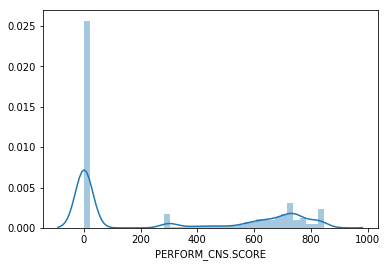

In [61]:
sns.distplot(df_train['PERFORM_CNS.SCORE'])

In [62]:
cns_score = cat_feature_vs_target(df_train, 'PERFORM_CNS.SCORE', 'loan_default')

In [63]:
cns_score.head()

,PERFORM_CNS.SCORE,loan_default,% age,total
0,0,27052,23.131253,116950
1,11,0,0.000000,3
2,14,208,21.311475,976
3,15,963,25.577689,3765
4,16,530,18.370884,2885


In [64]:
df_train['loan_default'].value_counts()

0    182543
1     50611
Name: loan_default, dtype: int64

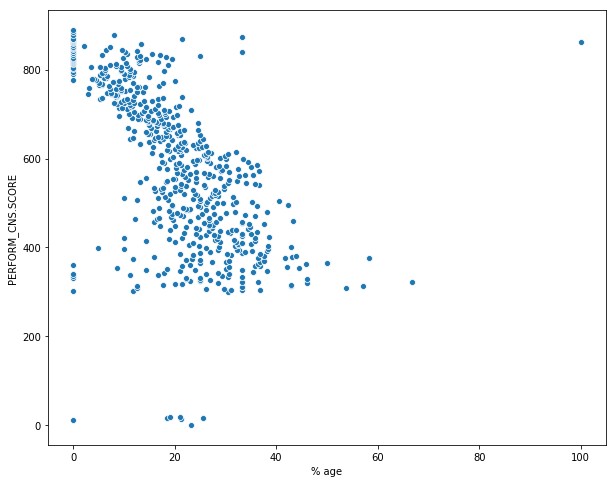

In [65]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=cns_score, x= '% age', y='PERFORM_CNS.SCORE')

#### PERFORM_CNS.SCORE.DESCRIPTION

In [66]:
cns_desc = cat_feature_vs_target(df_train, 'PERFORM_CNS.SCORE.DESCRIPTION', 'loan_default')

In [67]:
cns_desc.sort_values(by='% age', ascending=False)

,PERFORM_CNS.SCORE.DESCRIPTION,loan_default,% age,total
12,M-Very High Risk,2673,30.458067,8776
11,L-Very High Risk,318,28.042328,1134
10,K-High Risk,2302,27.812009,8277
8,I-Medium Risk,1515,27.262912,5557
19,Not Scored: Sufficient History Not Available,963,25.577689,3765
9,J-High Risk,946,25.240128,3748
7,H-Medium Risk,1658,24.186725,6855
13,No Bureau History Available,27052,23.131253,116950
18,Not Scored: Only a Guarantor,208,21.311475,976
17,Not Scored: Not Enough Info available on the c...,770,20.969499,3672


In [68]:
def woe(X, feat, target):
    woe = pd.DataFrame(
                    {'1s' :X.groupby(by=feat).sum()[target],
                     'Total' : X.groupby(by=feat).count()[target]})
    woe['0s'] = woe['Total'] - woe['1s']
    
    #woe.reset_index(level=0)
    total_good = woe['1s'].sum()
    total_bad = woe['0s'].sum()
    a = np.log(woe['1s'].values/total_good)
    b = np.log(woe['0s'].values/total_bad) 
    woe['WOE'] = a - b
    sums = woe.sum()
    woe['% Event'] = woe['1s']/woe.sum()['1s']
    woe['% NonEvent'] = woe['0s']/woe.sum()['0s']
    woe['IV'] = (woe['% Event'] - woe['% NonEvent']) * woe['WOE']
    return pd.concat([woe, cat_feature_vs_target(X, feat, target).set_index(feat)['% age']], axis=1)

In [69]:
woe_cns_desc = woe(df_train, 'PERFORM_CNS.SCORE.DESCRIPTION', 'loan_default').sort_values(by='% age', ascending= False)
woe_cns_desc

C:\Users\Elysium\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


,1s,Total,0s,WOE,% Event,% NonEvent,IV,% age
PERFORM_CNS.SCORE.DESCRIPTION,,,,,,,,
M-Very High Risk,2673,8776,6103,0.457238,0.052815,0.033433,0.008862,30.458067
L-Very High Risk,318,1134,816,0.340454,0.006283,0.004470,0.000617,28.042328
K-High Risk,2302,8277,5975,0.329011,0.045484,0.032732,0.004196,27.812009
I-Medium Risk,1515,5557,4042,0.301493,0.029934,0.022143,0.002349,27.262912
Not Scored: Sufficient History Not Available,963,3765,2802,0.214782,0.019027,0.015350,0.000790,25.577689
J-High Risk,946,3748,2802,0.196971,0.018692,0.015350,0.000658,25.240128
H-Medium Risk,1658,6855,5197,0.140347,0.032760,0.028470,0.000602,24.186725
No Bureau History Available,27052,116950,89898,0.081902,0.534508,0.492476,0.003443,23.131253
Not Scored: Only a Guarantor,208,976,768,-0.023435,0.004110,0.004207,0.000002,21.311475


In [70]:
df_train['CNS_desc_map'] = df_train['PERFORM_CNS.SCORE.DESCRIPTION']
df_train[['CNS_desc_map']] = df_train[['CNS_desc_map']].apply(lambda x: x.map({
    'M-Very High Risk': 'Very High Risk', 'L-Very High Risk' : 'Very High Risk', 'K-High Risk': 'Very High Risk',
    'I-Medium Risk': 'High Risk','Not Scored: Sufficient History Not Available': 'High Risk',
    'J-High Risk': 'High Risk', 'H-Medium Risk' : 'High Risk', 'No Bureau History Available': 'Medium risk',
       'Not Scored: Only a Guarantor': 'Medium risk',
       'Not Scored: Not Enough Info available on the customer': 'Medium risk', 'G-Low Risk': 'Small risk',
       'Not Scored: No Updates available in last 36 months': 'Small risk', 'F-Low Risk': 'Small risk',
    'Not Scored: No Activity seen on the customer (Inactive)': 'Small risk',
    'C-Very Low Risk':'Least Risk',
    'E-Low Risk':'Least Risk', 
    'A-Very Low Risk':'Least Risk', 
    'D-Very Low Risk':'Least Risk',
    'B-Very Low Risk':'Least Risk', 
    'Not Scored: More than 50 active Accounts found':'Least Risk'
}))

In [71]:
woe_cns_desc = woe(df_train, 'CNS_desc_map', 'loan_default').sort_values(by='% age', ascending= False)
woe_cns_desc

,1s,Total,0s,WOE,% Event,% NonEvent,IV,% age
CNS_desc_map,,,,,,,,
Very High Risk,5293,18187,12894,0.392440,0.104582,0.070635,0.013322,29.103206
High Risk,5082,19925,14843,0.210993,0.100413,0.081312,0.004030,25.505646
Medium risk,28030,121598,93568,0.077404,0.553832,0.512581,0.003193,23.051366
Small risk,3188,16892,13704,-0.175477,0.062990,0.075073,0.002120,18.872839
Least Risk,9018,56552,47534,-0.379406,0.178183,0.260399,0.031193,15.946386


In [72]:
woe_cns_desc.sum()['IV']

0.05385867164459991

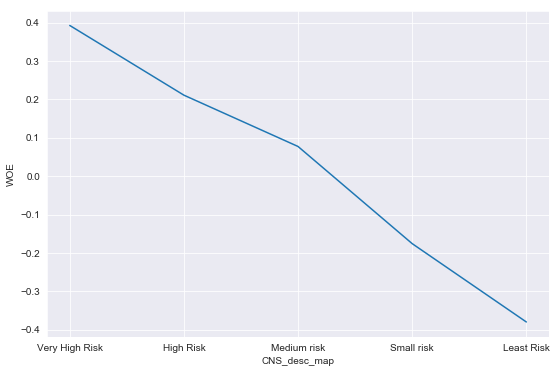

In [73]:
sns.set_style('darkgrid')
plt.figure(figsize=(9, 6))
sns.lineplot(x=woe_cns_desc.index, y=woe_cns_desc['WOE'], sort=False)

In [74]:
to_drop.append('PERFORM_CNS.SCORE.DESCRIPTION')

#### PRI.NO.OF.ACCTS

In [75]:
prim_acc = cat_feature_vs_target(df_train, 'PRI.NO.OF.ACCTS', 'loan_default')

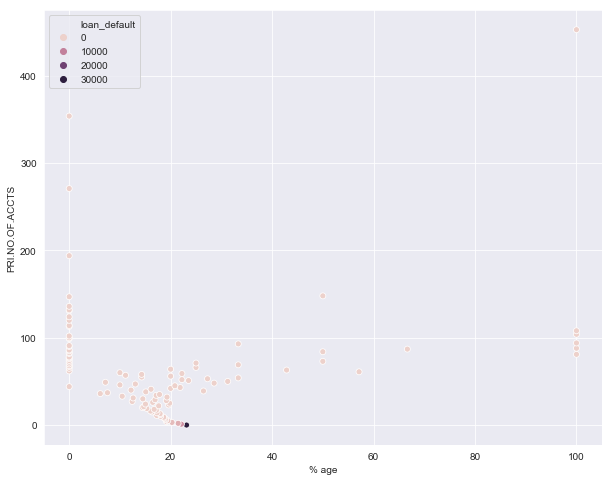

In [76]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=prim_acc, x= '% age', y='PRI.NO.OF.ACCTS', hue='loan_default')

In [95]:
def prim_accnts_map(X, label):
    X[label+'_map'] = pd.cut(X[label],
                                 [-1, 0, 1, 2, 3, 4, 8, 11, 21,51, 101, X[label].max()+1],
                                 include_lowest=False, right=False,
                                 labels=['Accnts_0',
                                         'Accnts_1','Accnts_2','Accnts_3','Accnts_4',
                                         'Accnts_8','Accnts_11',
                                        "Accnts_21",'Accnts_51',
                                        "Accnts_101",'Accnts_max'])
    return X

In [78]:
to_drop.append('PRI.NO.OF.ACCTS')

#### PRI.ACTIVE.ACCTS

In [79]:
prim_ac_active = cat_feature_vs_target(df_train, 'PRI.ACTIVE.ACCTS', 'loan_default')

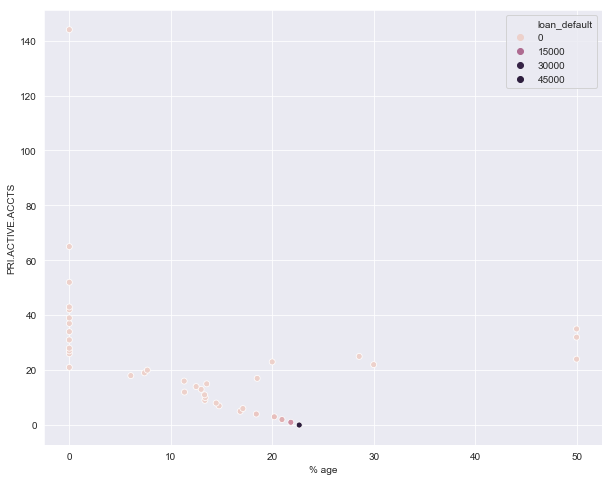

In [80]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=prim_ac_active, x= '% age', y='PRI.ACTIVE.ACCTS', hue='loan_default')

#### PRI.OVERDUE.ACCTS

In [81]:
# Leave as it is for SVM

#### PRI.CURRENT.BALANCE

In [82]:
def pri_current(X):
    X['PRI.CURRENT.BALANCE'] = X['PRI.CURRENT.BALANCE'] - X['PRI.CURRENT.BALANCE'].min() 
    return X

In [92]:
def prim_crr(X):
    X.loc[X['PRI.CURRENT.BALANCE']==0,'PRI.CURRENT.BALANCE'] = 1

In [90]:
log_labels.append('PRI.CURRENT.BALANCE')

#### PRI.SANCTIONED.AMOUNT

In [91]:
def san_amt(X):
    X.loc[X['PRI.SANCTIONED.AMOUNT']==0,'PRI.SANCTIONED.AMOUNT'] = 1

#### PRI.DISBURSED.AMOUNT

In [94]:
def disb_amt(X):
    X.loc[X['PRI.SANCTIONED.AMOUNT']==0,'PRI.SANCTIONED.AMOUNT'] = 1

#### SEC.NO.OF.ACCTS

In [96]:
# same as prim accounts
to_drop.append('SEC.NO.OF.ACCTS')

#### SEC.ACTIVE.ACCTS

In [ ]:
# same as prim active accounts
# Do Nothing

#### SEC.OVERDUE.ACCTS

In [97]:
# Leave as it is for SVM

#### SEC.CURRENT.BALANCE

In [100]:
def sec_current(X):
    X['SEC.CURRENT.BALANCE'] = X['SEC.CURRENT.BALANCE'] - X['SEC.CURRENT.BALANCE'].min() 
    return X
def sec_crr(X):
    X.loc[X['SEC.CURRENT.BALANCE']==0,'SEC.CURRENT.BALANCE'] = 1

In [99]:
log_labels.append('SEC.CURRENT.BALANCE')

#### SEC.SANCTIONED.AMOUNT

In [101]:
def sec_san_amt(X):
    X.loc[X['SEC.SANCTIONED.AMOUNT']==0,'SEC.SANCTIONED.AMOUNT'] = 1

In [102]:
log_labels.append('SEC.SANCTIONED.AMOUNT')

#### SEC.DISBURSED.AMOUNT

#### Model Building

In [ ]:
y_train = df_train.pop('loan_default')
X_train = df_train
X_test  = df_test

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42, stratify=y_train)